# Resilience study

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score , precision_score, recall_score, f1_score,\
            precision_recall_curve, confusion_matrix, plot_confusion_matrix

## Loading the dataset with selected features and target

In [2]:
dataset = pd.read_csv('./covid_dataset_sel.csv', index_col = 0, dtype = {'ID': str, 'RESILIENT_W1234': str})
dataset.head()

,ID,Edad,Sexo,Zona_vivienda,Pertenencia_vecindario,Comodidad_vencindario_llaves,Comodidad_vencindario_compra,Titulación,Situación_laboral,Adultos_vivienda,...,PEMBERTON_REMEMBERED,PEMBERTON_POSITIVE_EXPERIENCES,PEMBERTON_NEGATIVE_EXPERIENCES,PEMBERTON_EXPERIENCIAS,PEMBERTON_TOTAL,PI_total,PGT_SF_total,JTC_COVID,JTC_GENERAL,RESILIENT_W1234
0,1020597,47.0,Masculino,Urbana,Moderadamente,Algo cómodo,Algo cómodo,Formación profesional,Empleado tiempo completo,4,...,6.909091,2.0,4.0,6.0,6.833333,3.666667,36.0,2.5,1.0,0999
1,106149,47.0,Femenino,Rural,Ligeramente,Algo cómodo,Muy cómodo,Licenciatura,Empleado tiempo completo,2,...,8.636364,5.0,5.0,10.0,8.750000,3.166667,30.0,4.5,5.0,0999
2,1077997,73.0,Masculino,Rural,Mucho,Muy cómodo,Muy cómodo,Doctorado,Jubilado,2,...,9.090909,5.0,5.0,10.0,9.166667,3.833333,48.0,1.0,5.0,0999
3,1181910,49.0,Femenino,Urbana,Moderadamente,Muy cómodo,Muy cómodo,Formación profesional,Empleado tiempo completo,2,...,7.272727,5.0,4.0,9.0,7.416667,2.833333,41.0,1.0,2.0,0999
4,1469056,25.0,Femenino,Rural,Moderadamente,Algo cómodo,Algo cómodo,Formación profesional,Empleado medio tiempo,3,...,5.090909,4.0,4.0,8.0,5.333333,2.666667,25.0,1.5,1.5,1999


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 0 to 1950
Data columns (total 72 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                1944 non-null   object 
 1   Edad                              1944 non-null   float64
 2   Sexo                              1944 non-null   object 
 3   Zona_vivienda                     1944 non-null   object 
 4   Pertenencia_vecindario            1944 non-null   object 
 5   Comodidad_vencindario_llaves      1944 non-null   object 
 6   Comodidad_vencindario_compra      1944 non-null   object 
 7   Titulación                        1944 non-null   object 
 8   Situación_laboral                 1944 non-null   object 
 9   Adultos_vivienda                  1944 non-null   object 
 10  Menores_vivienda                  1944 non-null   int64  
 11  Descripción_lugar_vivienda        1944 non-null   object 
 12  Ingres

### Defining the target
The presence of distress was conceptualized as meeting standard cut-off scores in depression (PHQ-9), anxiety (GAD-7) or post-traumatic stress severity (ITQ). Although not of diagnostic value, this procedure allows for the identification of probable cases of psychological disorders.

Then, a mental health status classification was carried out by first, categorizing individuals according to whether they exhibited absence/presence of distress (i.e., reaching cutoff scores for either depression, anxiety or posttraumatic responses) and second, taking into account the assessment time-point (i.e., T1 and T2).

The combination of these two variables provided four different categories that tap the pattern of responses after traumatic events (Bonanno, 2004; Galatzer-Levy et al., 2018):
- Recovered (i.e., presence of distress at T1, absence at T2)
- Resilient (i.e., absence of distress at T1 and T2)
- Sustained distress (i.e., presence of distress at T1 and T2)
- Delayed distress (i.e., absence of distress at T1, presence at T2)

With this definition, lets create a new column `target_cat` from `RESILIENT_W1234`, given that:
- `9` means individual did not taket part of that wave survey.
- `0` means absence of distress (under cut-off point using `GAD7`, `PHQ9` and `ITQ`subscales)
- `1` means presence of distress (over cut-off point using `GAD7`, `PHQ9` and `ITQ`subscales)

In [4]:
dataset.loc[dataset['RESILIENT_W1234'].apply(lambda x: x[0:2]) == '00', 'target_cat'] = 'Resilient'
dataset.loc[dataset['RESILIENT_W1234'].apply(lambda x: x[0:2]) == '10', 'target_cat'] = 'Recovered'
dataset.loc[dataset['RESILIENT_W1234'].apply(lambda x: x[0:2]) == '11', 'target_cat'] = 'Sustained distress'
dataset.loc[dataset['RESILIENT_W1234'].apply(lambda x: x[0:2]) == '01', 'target_cat'] = 'Delayed distress'

In [5]:
# lets drop rows where at least one value is missing (will come just from this last column we created)
dataset.dropna(inplace = True)

In [6]:
dataset['target_cat'].value_counts()

Resilient             886
Sustained distress    419
Delayed distress      175
Recovered             144
Name: target_cat, dtype: int64

In [7]:
# lets create the final target 1 ('Resilient' + 'Recovered')
dataset['target_num'] = [1 if x in ['Resilient', 'Recovered'] else 0 for x in dataset['target_cat']]
dataset

,ID,Edad,Sexo,Zona_vivienda,Pertenencia_vecindario,Comodidad_vencindario_llaves,Comodidad_vencindario_compra,Titulación,Situación_laboral,Adultos_vivienda,...,PEMBERTON_NEGATIVE_EXPERIENCES,PEMBERTON_EXPERIENCIAS,PEMBERTON_TOTAL,PI_total,PGT_SF_total,JTC_COVID,JTC_GENERAL,RESILIENT_W1234,target_cat,target_num
323,1017726,42.0,Femenino,Urbana,Mucho,Muy incómodo,Algo cómodo,Master,Empleado tiempo completo,2,...,0.0,5.0,6.500000,1.666667,19.0,1.0,1.0,1199,Sustained distress,0
324,108162,46.0,Femenino,Urbana,Ligeramente,Algo incómodo,Algo incómodo,Licenciatura,Empleado medio tiempo,2,...,4.0,9.0,8.083333,4.166667,39.0,1.0,2.0,1199,Sustained distress,0
325,1111859,55.0,Masculino,Urbana,Ligeramente,Algo cómodo,Algo cómodo,Licenciatura,Empleado tiempo completo,2,...,5.0,9.0,7.666667,4.500000,36.0,8.5,7.5,0099,Resilient,1
326,1119736,59.0,Femenino,Urbana,Ligeramente,Algo cómodo,Algo cómodo,Master,Empleado medio tiempo,3,...,4.0,9.0,5.916667,3.333333,56.0,1.0,1.0,0099,Resilient,1
327,1151720,22.0,Femenino,Urbana,Moderadamente,Muy incómodo,Algo incómodo,Master,Estudiante,4,...,5.0,9.0,8.750000,3.333333,47.0,1.0,1.5,1099,Recovered,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,996007,45.0,Masculino,Urbana,Ligeramente,Algo incómodo,Algo incómodo,Grado universitario,Empleado tiempo completo,2,...,5.0,10.0,8.416667,2.333333,32.0,5.5,1.0,0000,Resilient,1
1947,997159,25.0,Masculino,Urbana,Moderadamente,Algo cómodo,Algo incómodo,Grado universitario,Empleado medio tiempo,2,...,4.0,5.0,6.833333,2.666667,33.0,3.0,3.5,0100,Delayed distress,0
1948,997683,67.0,Masculino,Rural,Mucho,Muy cómodo,Muy cómodo,Bachillerato,Jubilado,2,...,5.0,10.0,8.333333,3.666667,39.0,1.0,1.0,0000,Resilient,1
1949,997717,31.0,Masculino,Urbana,Ligeramente,Algo cómodo,Algo incómodo,Master,Empleado tiempo completo,2,...,3.0,6.0,5.416667,2.333333,32.0,5.5,2.0,0101,Delayed distress,0


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1624 entries, 323 to 1950
Data columns (total 74 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                1624 non-null   object 
 1   Edad                              1624 non-null   float64
 2   Sexo                              1624 non-null   object 
 3   Zona_vivienda                     1624 non-null   object 
 4   Pertenencia_vecindario            1624 non-null   object 
 5   Comodidad_vencindario_llaves      1624 non-null   object 
 6   Comodidad_vencindario_compra      1624 non-null   object 
 7   Titulación                        1624 non-null   object 
 8   Situación_laboral                 1624 non-null   object 
 9   Adultos_vivienda                  1624 non-null   object 
 10  Menores_vivienda                  1624 non-null   int64  
 11  Descripción_lugar_vivienda        1624 non-null   object 
 12  Ingr

### Overall probability of default

In [9]:
dataset['target_num'].mean()

0.6342364532019704

So we are not dealing with an umbalanced problem.

### Creating a modeling pipeline

accuracy_score_test 0.7758620689655172
accuracy_score_train 0.8004926108374384
precision_score_test 0.8156028368794326
precision_score_train 0.8189655172413793
recall_score_test 0.8550185873605948
recall_score_train 0.873850197109067
f1_score_test 0.8348457350272231
f1_score_train 0.845518118245391
auc_score_test 0.7377282717824871
auc_score_train 0.7760935887077063


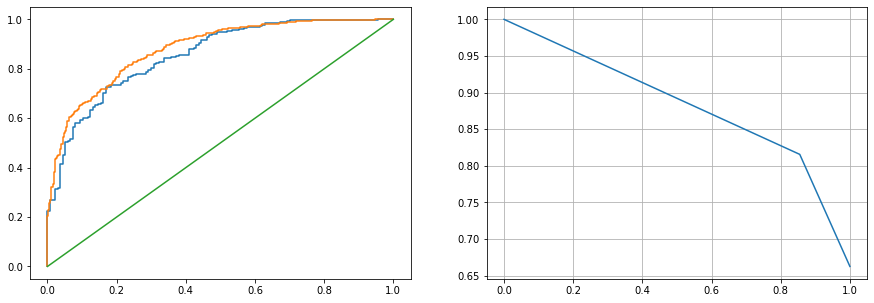

In [32]:
#separating target and features and droping features used to calculate target
target = dataset['target_num']
features = dataset.drop(['ID', 'PHQ_15_TOTAL', 'PHQ_9_TOTAL', 'GAD_TOTAL',
                         'PTSD_REEXP',
                         'PTSD_AVOID',
                         'PTSD_THREAT',
                         'PTSD_SEVERITY',
                         'PTSD_IMPAIR',
                         'PTSD_DIAGNOSIS',
                         'PTSD_TOTAL',
                         'SUBST_STRESS',
                         'DEP_DIAGN',
                         'RESILIENT_W1234', 'target_cat', 'target_num'], axis = 1)

#defining classifier
#classifier = DecisionTreeClassifier(min_samples_leaf = 45, min_samples_split = 110)
#classifier = RandomForestClassifier(min_samples_leaf=50, max_depth=4)
classifier = LogisticRegression(max_iter = 1000)

#separating numeric and categorical features
features_string = features.select_dtypes('object').columns
features_numeric = features.select_dtypes('number').columns

#defining preprocessing for categorical and numerical features 
numeric_preproc = Pipeline([('scaler', StandardScaler()),
                            ('pca', PCA())])

preproc = ColumnTransformer([('string_preproc', TargetEncoder(), features_string), 
                             ('numeric_preproc', numeric_preproc, features_numeric)])

#creating the modeling pipeline
pipeline = Pipeline([('preproc', preproc),
                     ('classifier', classifier)])

#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(features, target)

#trainning the model
pipeline.fit(X_train, y_train)

#making predictions
predictions_test = pipeline.predict(X_test)
predictions_proba_test = pipeline.predict_proba(X_test)
predictions_train = pipeline.predict(X_train)
predictions_proba_train = pipeline.predict_proba(X_train)

#evaluating the model
#metrics
accuracy_test = accuracy_score(y_test, predictions_test)
precision_test = precision_score(y_test, predictions_test)
recall_test = recall_score(y_test, predictions_test)
f1_test = f1_score(y_test, predictions_test)
auc_test = roc_auc_score(y_test, predictions_test)

accuracy_train = accuracy_score(y_train, predictions_train)
precision_train = precision_score(y_train, predictions_train)
recall_train = recall_score(y_train, predictions_train)
f1_train = f1_score(y_train, predictions_train)
auc_train = roc_auc_score(y_train, predictions_train)

print('accuracy_score_test', accuracy_test)
print('accuracy_score_train', accuracy_train)
print('precision_score_test', precision_test)
print('precision_score_train', precision_train)
print('recall_score_test', recall_test)
print('recall_score_train', recall_train)
print('f1_score_test', f1_test)
print('f1_score_train', f1_train)
print('auc_score_test', auc_test)
print('auc_score_train', auc_train)

precision, recall, _ = precision_recall_curve(y_test, predictions_test)
roc_rf_test = roc_curve(y_test, predictions_proba_test[:,1])
roc_rf_train = roc_curve(y_train, predictions_proba_train[:,1])

#plotting results
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(roc_rf_test[0], roc_rf_test[1]);
ax[0].plot(roc_rf_train[0], roc_rf_train[1]);
ax[0].plot([0, 1], [0, 1]);

ax[1].plot(recall, precision)
ax[1].grid()

In [23]:
cm = confusion_matrix(y_test, predictions_test)
print(cm)

[[ 99  47]
 [ 32 228]]


In [45]:
print(pipeline[0])

ColumnTransformer(transformers=[('string_preproc', TargetEncoder(),
                                 Index(['Sexo', 'Zona_vivienda', 'Pertenencia_vecindario',
       'Comodidad_vencindario_llaves', 'Comodidad_vencindario_compra',
       'Titulación', 'Situación_laboral', 'Adultos_vivienda',
       'Descripción_lugar_vivienda', 'Ingresos', 'pérdida_ingresos',
       'preocupación_economía_covid', 'Religión', 'CONFIANZA_EN_O...
       'PADS_TOTAL', 'CRT_TOTAL', 'LONELI', 'LMLOS_chance', 'LMLOS_powerful',
       'LMLOS_internal', 'OFS_total', 'BRS_total', 'Externallygenerated_DAI',
       'Meaning_DAI', 'Thoughts_DAI', 'Life_DAI', 'Brevity_DAI', 'DAI_TOTAL',
       'IUS_total', 'PEMBERTON_REMEMBERED', 'PEMBERTON_POSITIVE_EXPERIENCES',
       'PEMBERTON_NEGATIVE_EXPERIENCES', 'PEMBERTON_EXPERIENCIAS',
       'PEMBERTON_TOTAL', 'PI_total', 'PGT_SF_total', 'JTC_COVID',
       'JTC_GENERAL'],
      dtype='object'))])


In [12]:
columns_importance = pd.Series(classifier.feature_importances_, index=features.columns)
fig = plt.figure(figsize = (15, 8))
columns_importance.nlargest(9).plot(kind = 'barh');

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [ ]:
plt.figure(figsize = (20,20))
plot_tree(classifier,
              feature_names = features.columns.values,
              class_names = ['No', 'Sí'],
              filled = True,
              impurity = False,
              fontsize = 8)
plt.show()